In [154]:
# Packages
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
import pandas as pd
import numpy as np
from scipy.special import boxcox1p
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score
from sklearn.svm import SVR
from yellowbrick.regressor import ResidualsPlot, AlphaSelection, PredictionError
from yellowbrick.features.importances import FeatureImportances
from yellowbrick.features import RFECV
%matplotlib inline
import missingno

In [155]:
# Options
sns.set_style("whitegrid")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', -1)

#### Train Data

In [156]:
df = pd.read_csv('./data/transformed_data/model_all.csv')

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


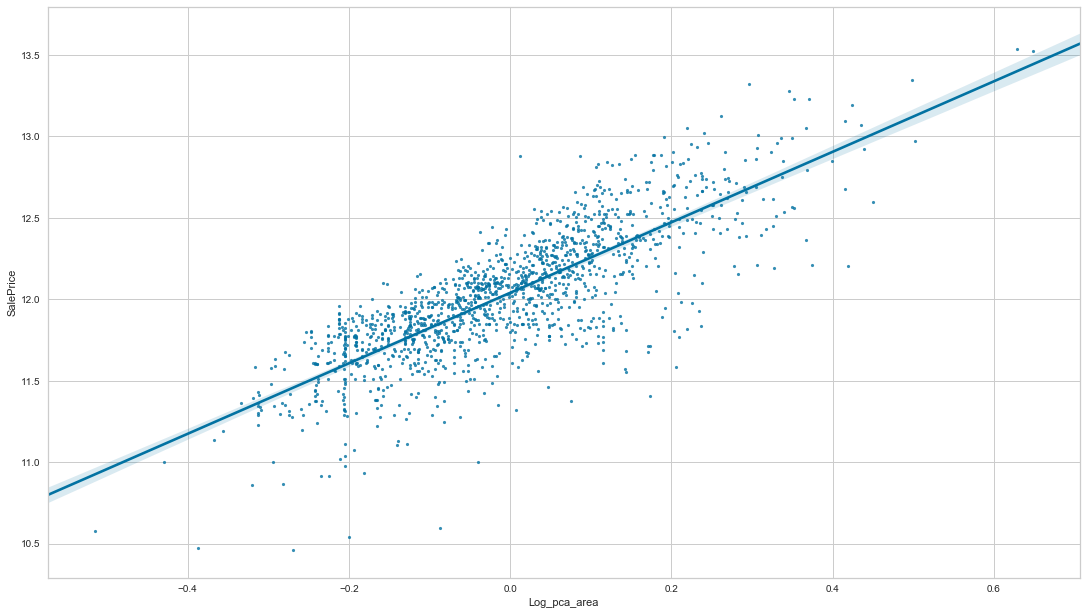

In [173]:
# PCA
pca = PCA(n_components=1)
df['Log_pca_area'] = np.log1p(pca.fit_transform(df[
    ['Raw_GrLivArea', 'Raw_CoreArea', 'Raw_TotalArea']
]))

ax = sns.regplot(x=df['Log_pca_area'], y=df['SalePrice'], scatter_kws={"s": 10})
ax.figure.set_size_inches(18.5, 10.5)

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


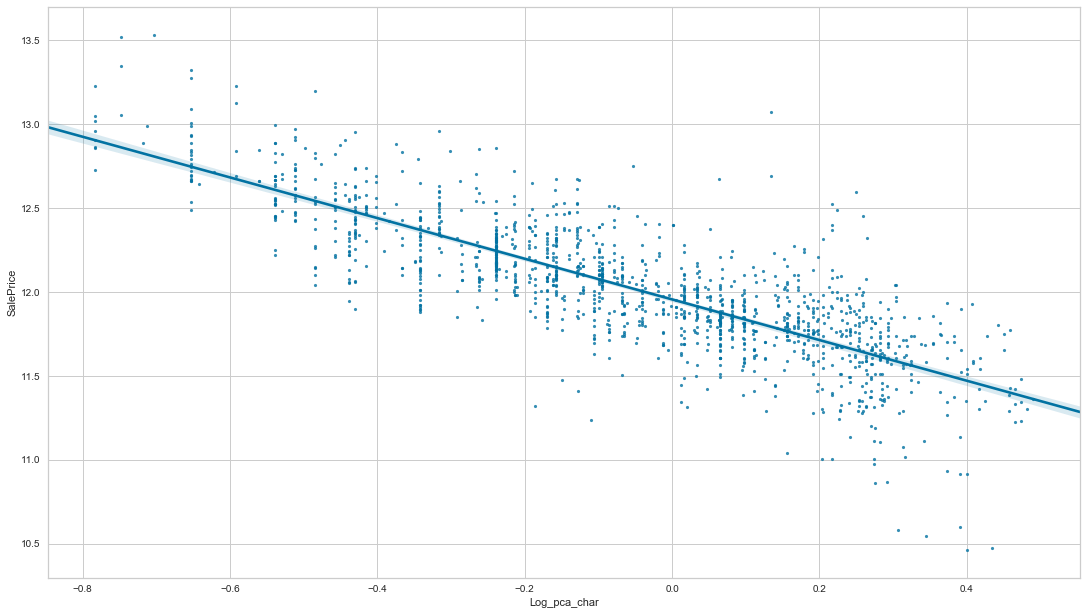

In [204]:
pca = PCA(n_components=1)
df['Log_pca_char'] = boxcox1p(pca.fit_transform(df[
    ['Raw_OverallQual', 'Raw_OverallCond', 'Log_Ord_Neighborhood']
]),-0.5)
ax = sns.regplot(x=df['Log_pca_char'], y=df['SalePrice'], scatter_kws={"s": 10})
ax.figure.set_size_inches(18.5, 10.5)

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


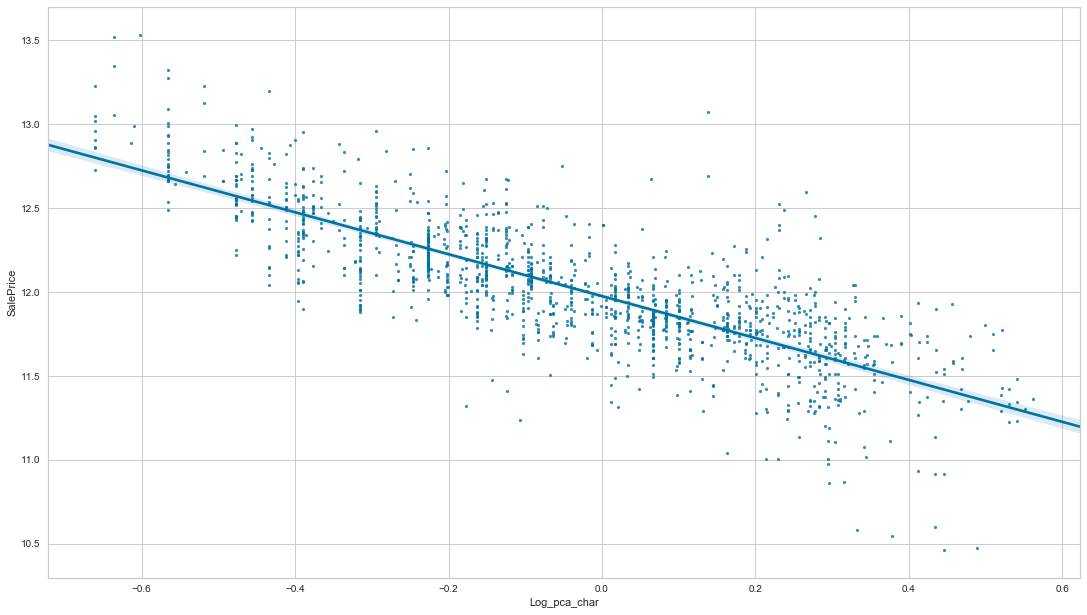

In [192]:
pca = PCA(n_components=1)
df['Log_pca_char'] = np.log1p(pca.fit_transform(df[
    ['Raw_OverallQual', 'Raw_OverallCond', 'Log_Ord_Neighborhood']
]))
ax = sns.regplot(x=df['Log_pca_char'], y=df['SalePrice'], scatter_kws={"s": 10})
ax.figure.set_size_inches(18.5, 10.5)

In [200]:
df_train = df[(df['Train']==1)].drop(['Train', 'Test'], axis=1)
df_sub = df[(df['Test']==1)].drop(['Train', 'Test'], axis=1)

#### Linear Exploration

In [201]:
target = df_train['SalePrice']
drop_vars = ['Id', 'SalePrice']

features_linear = df_train.drop(drop_vars, axis=1)
sub_features_linear = df_sub.drop(drop_vars, axis=1)

features_linear = features_linear[features_linear.columns.drop(list(features_linear.filter(regex='Lbl_')))]
features_linear = features_linear[features_linear.columns.drop(list(features_linear.filter(regex='Raw_')))]
# features_linear = features_linear[features_linear.columns.drop(list(features_linear.filter(regex='1h_')))]

train_features, test_features, train_target, test_target = train_test_split(
    features_linear, 
    target, 
    test_size=0.2, 
    random_state = 3
)

model = Lasso()
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.03, 0.06, 0.1, 0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}
gs = GridSearchCV(
    cv=20, 
    estimator=model,
    param_grid=param_grid, 
    scoring='neg_mean_squared_error'
)
gs.fit(train_features, train_target)
test_score = abs(gs.score(test_features, test_target))
print('Grid Search Score: {}'.format(np.sqrt(abs(gs.best_score_))))
print('Test Val Score: {}'.format(np.sqrt(abs(test_score))))
print('Best Parameters: {}'.format(gs.best_params_))

Grid Search Score: 0.1152373422337689
Test Val Score: 0.11449430576178134
Best Parameters: {'alpha': 0.001}


#### Alpha Error

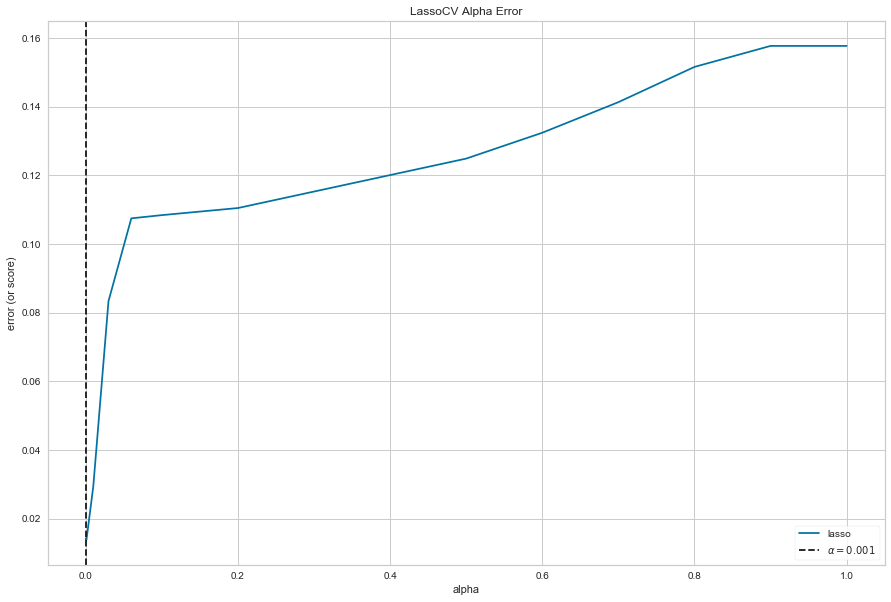

In [85]:
lasso_cv = LassoCV(
    cv=20, 
    alphas=param_grid['alpha']
)
visualizer = AlphaSelection(lasso_cv, size=(1080, 720))
visualizer.fit(train_features, train_target)
g = visualizer.poof()

#### Residuals

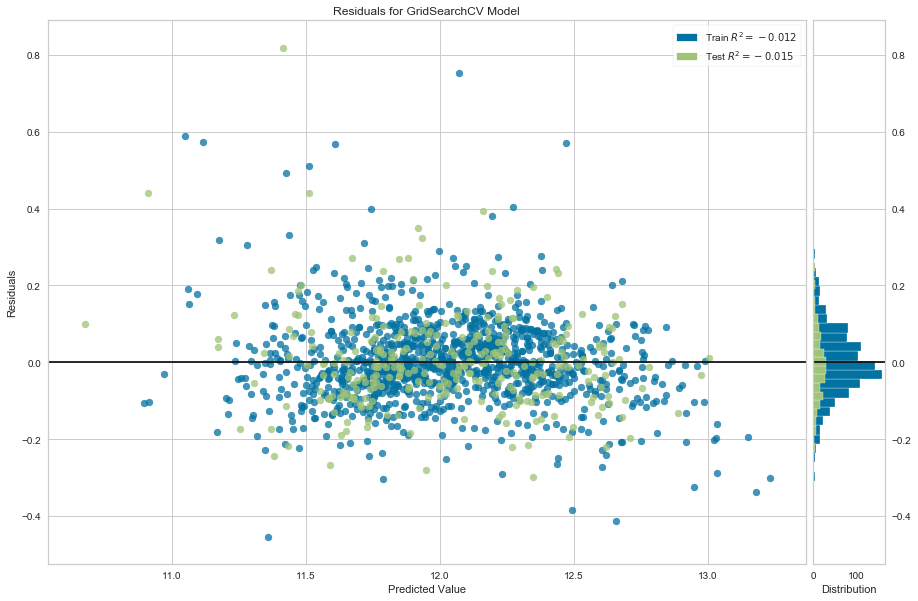

In [81]:
visualizer = ResidualsPlot(gs, size=(1080, 720))
visualizer.fit(train_features, train_target)
visualizer.score(test_features, test_target)
g = visualizer.poof()

#### Prediction Error

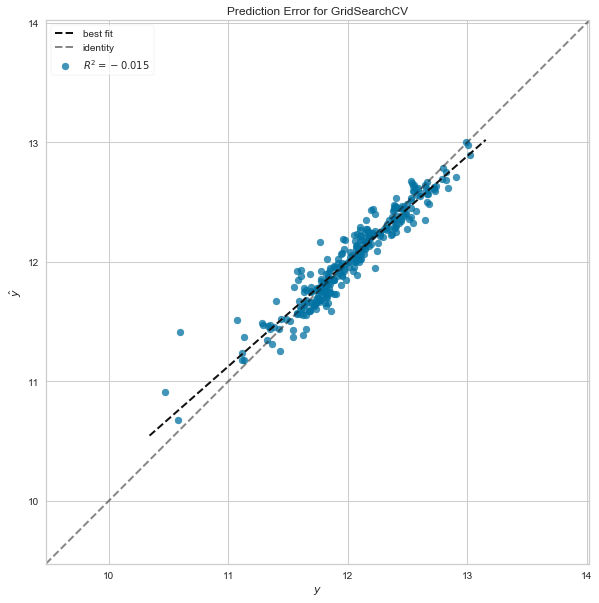

In [82]:
visualizer = PredictionError(gs, size=(1080, 720))
visualizer.fit(train_features, train_target)
visualizer.score(test_features, test_target)
g = visualizer.poof()

#### Feature Importance

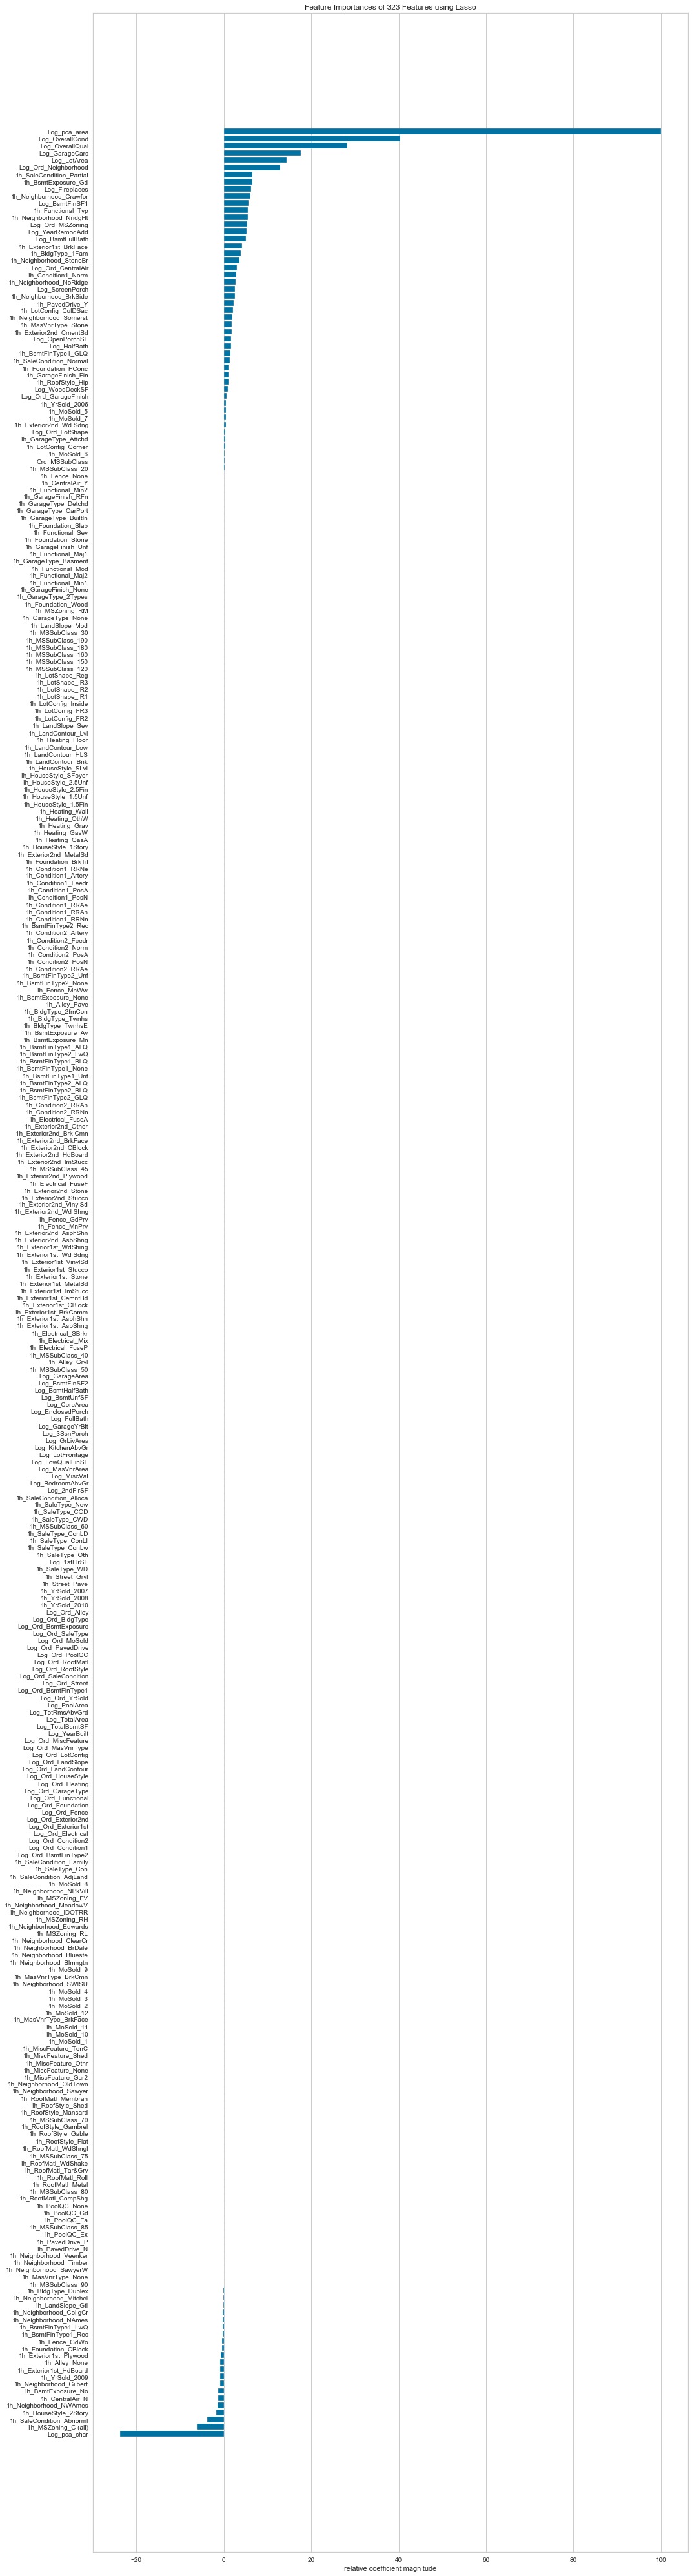

In [202]:
# Create a new figure
fig = plt.figure()
ax = fig.add_subplot()
viz = FeatureImportances(gs.best_estimator_, ax=ax, size=(1080, 4000))
viz.fit(train_features, train_target)
viz.poof()

#### Model Iterator

In [91]:
linear_models = [{
    'name': 'Linear',
    'estimator': LinearRegression(),
    'param_grid': {
    }
}, {
    'name': 'Ridge',
    'estimator': Ridge(),
    'param_grid': {
        'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.03, 0.06, 0.1, 0.2, 0.5, 1, 5, 10],
    }
},{
    'name': 'Lasso',
    'estimator': Lasso(),
    'param_grid': {
        'alpha': [0.0001, 0.001, 0.01, 0.03, 0.06, 0.1, 0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
},{
    'name': 'ElasticNet',
    'estimator': ElasticNet(),
    'param_grid': {
        'alpha': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 10],
        'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
    }
}]

In [415]:
tree_models = [
# {
#     'name': 'XGBoost',
#     'estimator': XGBRegressor(),  
#     'param_grid': {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#     }
# },
{
    'name': 'Random Forest Regressor',
    'estimator': RandomForestRegressor(),
    'param_grid': {
        'max_depth': [4,5,6],
        'n_estimators': [100, 150],
        'min_samples_split':[2,3,4],
        'min_samples_leaf':[2,3,4]
    }
},{
    'name': 'Gradient Boosting Regressor',
    'estimator': GradientBoostingRegressor(),
    'param_grid': {
        'n_estimators':[100], 
        'learning_rate': [0.1, 0.05, 0.02, 0.01], 
        'max_depth':[4,5,6], 
        'min_samples_leaf':[3,5,9,17], 
        'max_features':[1.0 ,0.3 ,0.1] 
    } 
}]

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


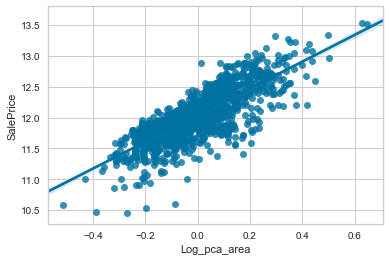

#### Linear Grid Search

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Linear Report

Grid Search Score: 11368302752.252636
Test Val Score: 0.14619154494087488
Best Parameters: {}
---------------------------------------------

Ridge Report

Grid Search Score: 0.11908209578643959
Test Val Score: 0.12613595958411375
Best Parameters: {'alpha': 5}
---------------------------------------------

Lasso Report

Grid Search Score: 0.11526301599289833
Test Val Score: 0.12194866371015274
Best Parameters: {'alpha': 0.001}
---------------------------------------------

ElasticNet Report

Grid Search Score: 0.11408667748399558
Test Val Score: 0.11833864329000383
Best Parameters: {'alpha': 0.001, 'l1_ratio': 0.5}
---------------------------------------------



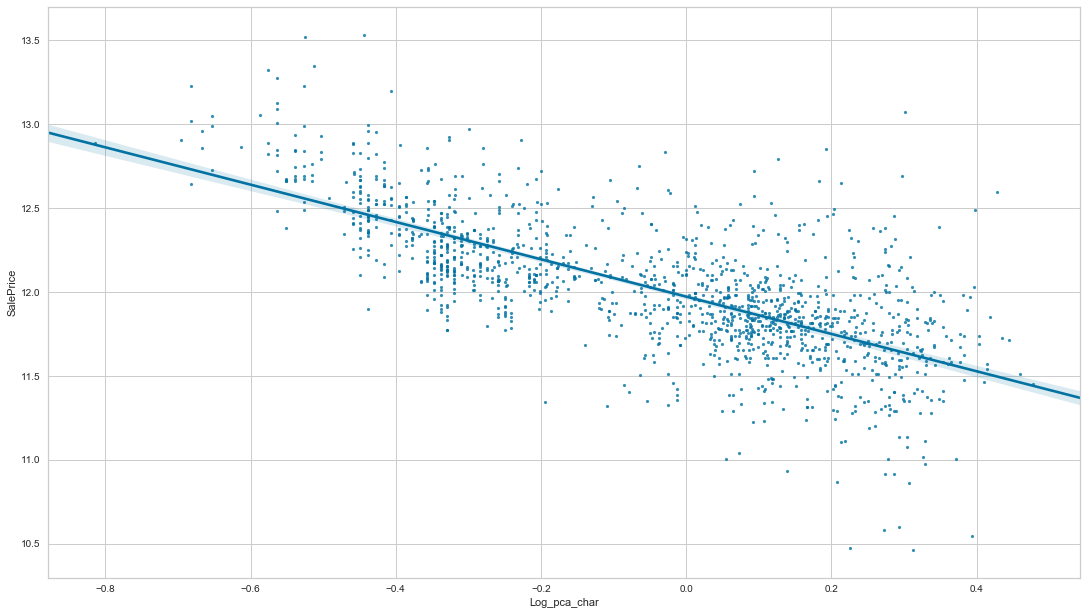

In [199]:
drop_vars = ['Id', 'SalePrice']
df = pd.read_csv('./data/transformed_data/model_all.csv')

pca = PCA(n_components=1)
df['Log_pca_area'] = np.log1p(pca.fit_transform(df[
    ['Raw_GrLivArea', 'Raw_CoreArea', 'Raw_TotalArea']
]))

pca = PCA(n_components=1)
df['Log_pca_char'] = boxcox1p(pca.fit_transform(df[
    ['Raw_OverallQual', 'Raw_OverallCond', 'Log_YearBuilt']
]),-0.5)


ax = sns.regplot(x=df['Log_pca_char'], y=df['SalePrice'], scatter_kws={"s": 10})
ax.figure.set_size_inches(18.5, 10.5)

df_train = df[(df['Train']==1)].drop(['Train', 'Test'], axis=1)
df_sub = df[(df['Test']==1)].drop(['Train', 'Test'], axis=1)

target = df_train['SalePrice']
features_linear = df_train.drop(drop_vars, axis=1)
features_linear_sub = df_sub.drop(drop_vars, axis=1)

features_linear = features_linear[features_linear.columns.drop(list(features_linear.filter(regex='Lbl_')))]
features_linear = features_linear[features_linear.columns.drop(list(features_linear.filter(regex='Raw_')))]

train_features, test_features, train_target, test_target = train_test_split(
    features_linear, 
    target, 
    test_size=0.2, 
    random_state = 42
)

linear_models_output = []

for item in linear_models:
    
    gs = GridSearchCV(
        cv=20, 
        estimator=item['estimator'],
        param_grid=item['param_grid'], 
        scoring='neg_mean_squared_error'
    )
    gs.fit(train_features, train_target)
    test_score = gs.score(test_features, test_target)
    
    try:    
        output_dict = {
            'name': item['name'],
            'model': gs.best_estimator_,
            'coefs': gs.best_estimator_.coef_,
            'gs_score': np.sqrt(abs(test_score)),
            'test_score': np.sqrt(abs(test_score)),
            'best_estimator': gs.best_estimator_
        }
        
    except:
        
        output_dict = {
            'name': item['name'],
            'model': gs.best_estimator_,
            'coefs': None,
            'gs_score': np.sqrt(abs(test_score)),
            'test_score': np.sqrt(abs(test_score)),
            'best_estimator': gs.best_estimator_
        }
        
    linear_models_output.append(output_dict)
    
    print(item['name'] + ' Report')
    print()
    print('Grid Search Score: {}'.format(np.sqrt(abs(gs.best_score_))))
    print('Test Val Score: {}'.format(np.sqrt(abs(test_score))))
    print('Best Parameters: {}'.format(gs.best_params_))
    print('---------------------------------------------')
    print()

In [416]:
drop_vars = ['Id', 'SalePrice']
df = pd.read_csv('./data/transformed_data/model_all.csv')
df = df[df.columns.drop(list(df.filter(regex='1h_')))]
df = df[df.columns.drop(list(df.filter(regex='Ord_')))]

pca = PCA(n_components=1)
df = apply_pca(df, pca_vars)

df_train = df[(df['Train']==1)].drop(['Train', 'Test'], axis=1)
df_sub = df[(df['Test']==1)].drop(['Train', 'Test'], axis=1)

target = df_train['SalePrice']
linear_features = df_train.drop(drop_vars, axis=1)
linear_sub_features = df_sub.drop(drop_vars, axis=1)

train_features, test_features, train_target, test_target = train_test_split(
    linear_features, 
    target, 
    test_size=0.2, 
    random_state = 42
)

for item in tree_models:
    
    gs = GridSearchCV(
        cv=20, 
        estimator=item['estimator'],
        param_grid=item['param_grid'], 
        scoring='neg_mean_squared_error'
    )
    gs.fit(train_features, train_target)
    test_score = gs.score(test_features, test_target)
    
    try:    
        output_dict = {
            'name': item['name'],
            'model': gs.best_estimator_,
            'coefs': gs.best_estimator_.coef_,
            'gs_score': np.sqrt(abs(test_score)),
            'test_score': np.sqrt(abs(test_score)),
            'best_estimator': gs.best_estimator_
        }
        
    except:
        
        output_dict = {
            'name': item['name'],
            'model': gs.best_estimator_,
            'coefs': None,
            'gs_score': np.sqrt(abs(test_score)),
            'test_score': np.sqrt(abs(test_score)),
            'best_estimator': gs.best_estimator_
        }
        
    tree_models_output.append(output_dict)
    
    print(item['name'] + ' Report')
    print()
    print('Grid Search Score: {}'.format(np.sqrt(abs(gs.best_score_))))
    print('Test Val Score: {}'.format(np.sqrt(abs(test_score))))
    print('Best Parameters: {}'.format(gs.best_params_))
    print('---------------------------------------------')
    print()

KeyboardInterrupt: 

In [209]:
features_linear_sub = features_linear_sub[features_linear_sub.columns.drop(list(features_linear_sub.filter(regex='Lbl_')))]
features_linear_sub = features_linear_sub[features_linear_sub.columns.drop(list(features_linear_sub.filter(regex='Raw_')))]

df_sub = pd.DataFrame()
df_sub['Id'] = df[(df['Test']==1)]['Id']
predictions = linear_models_output[3]['best_estimator'].predict(features_linear_sub)
df_sub['SalePrice'] = np.expm1(predictions)
df_sub.to_csv('./data/output_data/elastic_submission_7.csv', index=False)

#### Stacking

In [70]:
df_sub = pd.DataFrame()
df_sub['Id'] = df_sub_in['Id']

for result in model_output:
    model = result['model']
    model.fit(features[keep_vars], target)
    predictions = model.predict(sub_features[keep_vars])
    col = result['name']
    df_sub[col] = np.expm1(predictions)
    
df_sub.drop('SVR')
    
df_sub['SalePrice'] = df_sub.mean(axis=1)
    
df_sub[['Id','SalePrice']].to_csv('./data/output_data/stacks.csv', index=False)

In [74]:
model_output[2]

{'name': 'Lasso',
 'model': Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'coefs': array([-0.85048872,  0.31467513, -0.09070981,  0.0973368 , -0.47238302,
         0.18140405, -0.        ,  0.08311501,  0.13498605,  0.31053983,
         0.09068065, -0.        , -0.04661893,  0.10084236,  0.07626998,
         0.14186626, -0.02913066,  0.00142048, -0.03352754,  0.03495216,
         0.05223684,  0.00463962,  0.15423794, -0.05450783, -0.01210846,
        -0.11743765, -0.0337748 , -0.        , -0.00277848,  0.00113537,
        -0.00928474,  0.0830963 ,  0.07473223, -0.07684975, -0.01965239,
        -0.        , -0.02132999,  0.03199852,  0.1097871 ,  0.02423317,
         0.06759975]),
 'gs_score': 0.12727645876928415,
 'test_score': 0.12727645876928415,
 'best_params': {'alpha': 0.0001}}

#### Final Model

In [75]:
# Final Model
model = Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False)

model.fit(features[keep_vars], target)

# Submission
df_sub = pd.DataFrame()
df_sub['Id'] = df_sub_in['Id']
predictions = model.predict(sub_features[keep_vars])
df_sub['SalePrice'] = np.expm1(predictions)
df_sub.to_csv('./data/output_data/lasso_submission.csv', index=False)

#### Lasso

In [ ]:
alphas = [0.01, 0.03, 0.06, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 5, 10, 50]
lasso = LassoCV(alphas=alphas, cv=20)
validate_model(lasso, train_features, train_target, test_features, test_target)

In [ ]:
coefs = lasso.coef_
plt.figure(figsize=(6, 20))
plt.barh(np.arange(coefs.size), coefs)
plt.yticks(np.arange(coefs.size), train_features)
plt.title("Coefficients")
plt.tight_layout()

#### Elastic

In [ ]:
l1_ratio=0
alphas=[0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 10],
elastic = ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas, max_iter=5000, cv=20)
validate_model(elastic, train_features, train_target, test_features, test_target)

#### Bayesian Ridge

In [ ]:
param_grid = {
    'alpha_1': [0.00001, 0.0001, 0.001, 0.01, 0.03, 0.06, 0.1, 0.2, 0.5, 1],
    'alpha_2': [10, 20, 30],
    'lambda_1': [0.00001, 0.0001, 0.001],
    'lambda_2': [10, 20, 30]
}

bayes = GridSearchCV(cv=5, estimator=BayesianRidge(), param_grid=param_grid)
validate_model(bayes, train_features, train_target, test_features, test_target)
params = bayes.best_params_
params

In [ ]:
bayes = BayesianRidge(alpha_1=0.00001, alpha_2=30, lambda_1=0.001, lambda_2=10)
bayes.fit(features, target)

# Submission
df_sub = pd.DataFrame()
df_sub['Id'] = df_sub_in['Id']
df_sub['SalePrice'] = np.round(np.expm1(bayes.predict(sub_features)),0)
df_sub['SalePrice'] = (df_sub['SalePrice'] / 100).astype(int) * 100
df_sub.to_csv('./data/output_data/bayes_submission.csv', index=False)

#### Ridge Prediction Error

In [ ]:
visualizer = PredictionError(ridge)
visualizer.fit(features, target)  
visualizer.poof()             

#### Ridge Submission

In [ ]:
predictions = ridge.predict(test_features)
df_sub = pd.DataFrame()
df_sub['Id'] = df_test_in['Id']
df_sub['SalePrice'] = np.expm1(ridge.predict(test_features))
df_sub.to_csv('./data/output_data/ridge_submission.csv', index=False)

#### Lasso

In [ ]:
scoring = make_scorer(mean_squared_error)
alphas = [0.01, 0.03, 0.06, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 5, 10, 50]
lasso = LassoCV(alphas=alphas)
lasso.fit(features, target)
mse = cross_val_score(lasso, features, target, cv=20, scoring=scoring)
rmse = np.sqrt(mse)
score = np.mean(rmse)
score

#### Lasso Coefficients

In [ ]:
coefs = lasso.coef_
plt.figure(figsize=(6, 20))
plt.barh(np.arange(coefs.size), coefs)
plt.yticks(np.arange(coefs.size), features)
plt.title("Coefficients")
plt.tight_layout()

#### Lasso Submission

In [ ]:
predictions = lasso.predict(test_features)
df_sub = pd.DataFrame()
df_sub['Id'] = df_test_in['Id']
df_sub['SalePrice'] = np.expm1(lasso.predict(test_features))
df_sub.to_csv('./data/output_data/lasso_submission.csv', index=False)

#### ElasticNet

In [ ]:
scoring = make_scorer(mean_squared_error)
l1_ratio=0.5,
alphas=[0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 10],
elastic = ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas, max_iter=5000)
elastic.fit(features, target)
elastic_score = np.mean(np.sqrt(cross_val_score(elastic, features, target, cv=20, scoring=scoring)))
elastic_score

In [ ]:
coefs = elastic.coef_
plt.figure(figsize=(6, 20))
plt.barh(np.arange(coefs.size), coefs)
plt.yticks(np.arange(coefs.size), features)
plt.title("Coefficients")
plt.tight_layout()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
train_features_2 = poly.fit_transform()
test_features_2 = poly.fit_transform(test_features)

In [ ]:
train_features_2

In [151]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(train_features, train_target)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)